### Import necessary libraries

In [270]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split

# Enter what you want to predict here:

In [271]:
symbol = input('Enter the ticket symbol you want to predict(For example: GOAU, BTCUSDT,...): ')

date_format = "%Y-%m-%d"
today = date.today()
print('Today is ', today)
three_days_from_now = today + timedelta(days=3)

while True:
    end_date_str = input('Enter the date you want to predict (YYYY-MM-DD): ')

    try:
        end_date = datetime.strptime(end_date_str, date_format)
        
        if end_date.date() <= today or end_date.date() > three_days_from_now:
            print("Please enter a date after today and within the next 3 days.")
        else:
            break

    except ValueError:
        print("Incorrect date format. Please enter the date in the format YYYY-MM-DD.")


Enter the ticket symbol you want to predict(For example: GOAU, BTCUSDT,...): FRC
Today is  2023-03-19
Enter the date you want to predict (YYYY-MM-DD): 2023-03-20


### Get API key to import data 

In [272]:
api_key = 'EAIGVRY4DNE2XX0W' #Get an API key from https://www.alphavantage.co/support/#api-key and paste it in here

start_date = '2022-10-01'
end_date = str(today)

url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    time_series_data = data['Time Series (Daily)']
    df = pd.DataFrame(time_series_data).T
    df.index = pd.to_datetime(df.index)
    df = df.astype(float)

    # Filter data for the desired date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Save the filtered data as a CSV file
    filtered_df.to_csv(f'{symbol}_daily_adjusted_{start_date}_to_{end_date}.csv')
else:
    print(f'Error: Unable to fetch data (HTTP status code {response.status_code})')

## Preprocessing Data

In [273]:
# filename = 'GOAU_daily_adjusted_2022-10-01_to_2023-03-01.csv'
filename = f'{symbol}_daily_adjusted_{start_date}_to_{end_date}.csv'

df = pd.read_csv(filename, index_col=0, parse_dates=True)


In [274]:
print(df.isna().sum())

1. open                 0
2. high                 0
3. low                  0
4. close                0
5. adjusted close       0
6. volume               0
7. dividend amount      0
8. split coefficient    0
dtype: int64


In [275]:
df.shape

(115, 8)

In [276]:
df.describe()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
count,115.000000,115.000000,115.000000,115.000000,115.000000,1.150000e+02,115.000000,115.0
mean,120.803287,123.350275,118.436530,120.934609,120.728069,8.173018e+06,0.004696,1.0
std,21.738899,20.044022,23.060178,21.534931,21.502024,2.928402e+07,0.035450,0.0
min,20.220000,30.010000,17.530000,23.030000,23.030000,4.558830e+05,0.000000,1.0
25%,119.130000,120.520000,116.562500,118.740000,118.507666,1.195940e+06,0.000000,1.0
50%,122.840000,124.500000,120.920000,122.810000,122.739370,1.518261e+06,0.000000,1.0
75%,130.205000,133.259500,129.275650,130.855000,130.726848,2.306869e+06,0.000000,1.0
max,145.000000,147.680000,143.480000,147.000000,147.000000,1.960800e+08,0.270000,1.0


## Data Visualization

Text(0.5, 1.0, 'FRC Opening Price')

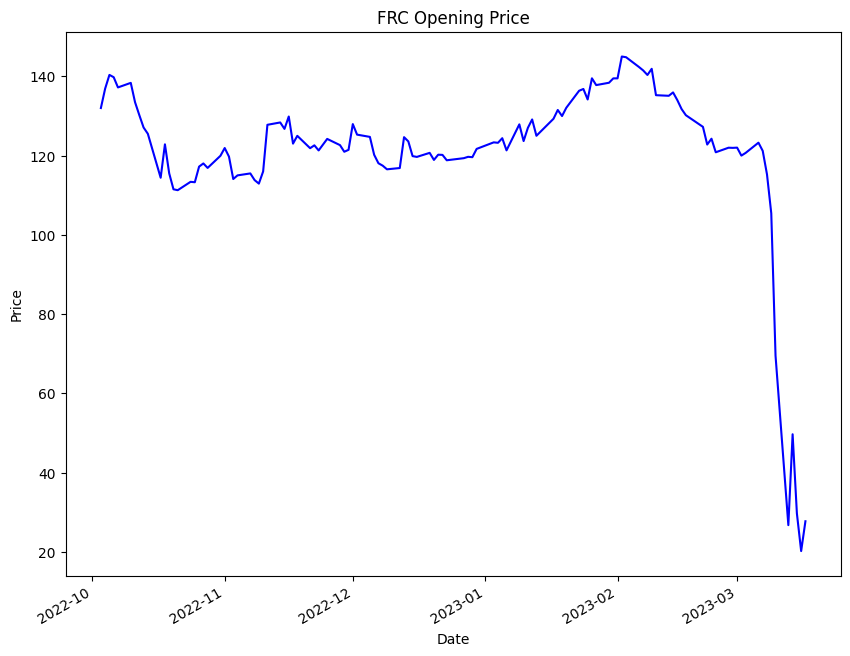

In [277]:
df['1. open'].plot(figsize = (10, 8), color ="b")
plt.ylabel('Price')
plt.xlabel('Date')
plt.title(f"{symbol} Opening Price")

Text(0.5, 1.0, 'FRC Highest Price')

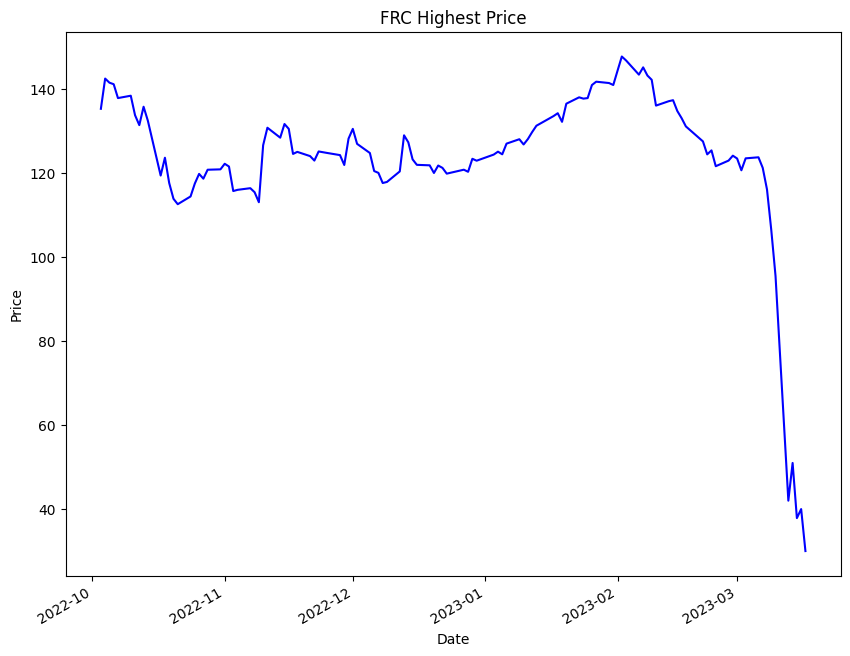

In [278]:
df['2. high'].plot(figsize = (10, 8), color ="b")
plt.ylabel('Price')
plt.xlabel('Date')
plt.title(f"{symbol} Highest Price")

Text(0.5, 1.0, 'FRC Closing Price')

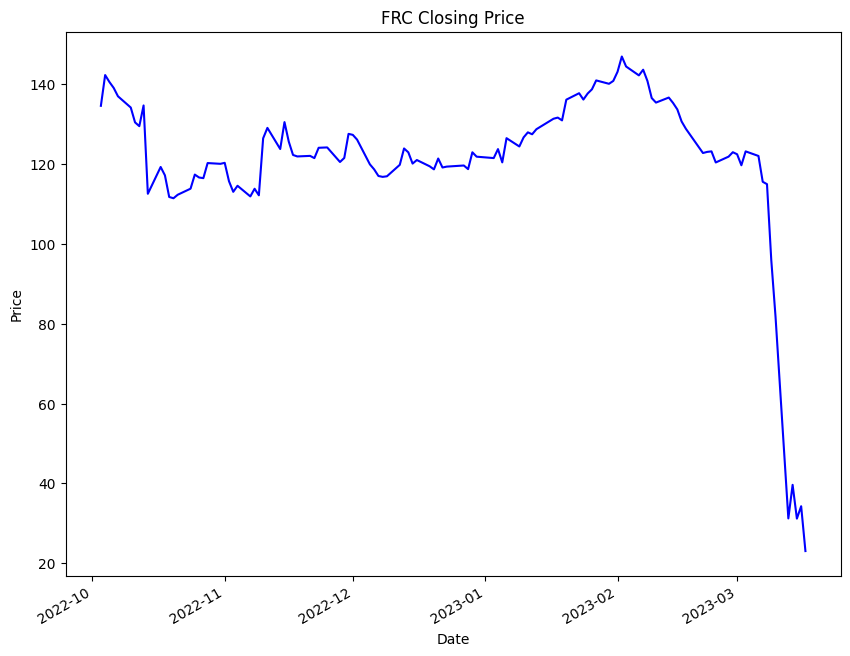

In [279]:
df['4. close'].plot(figsize = (10, 8), color ="b")
plt.ylabel('Price')
plt.xlabel('Date')
plt.title(f"{symbol} Closing Price")

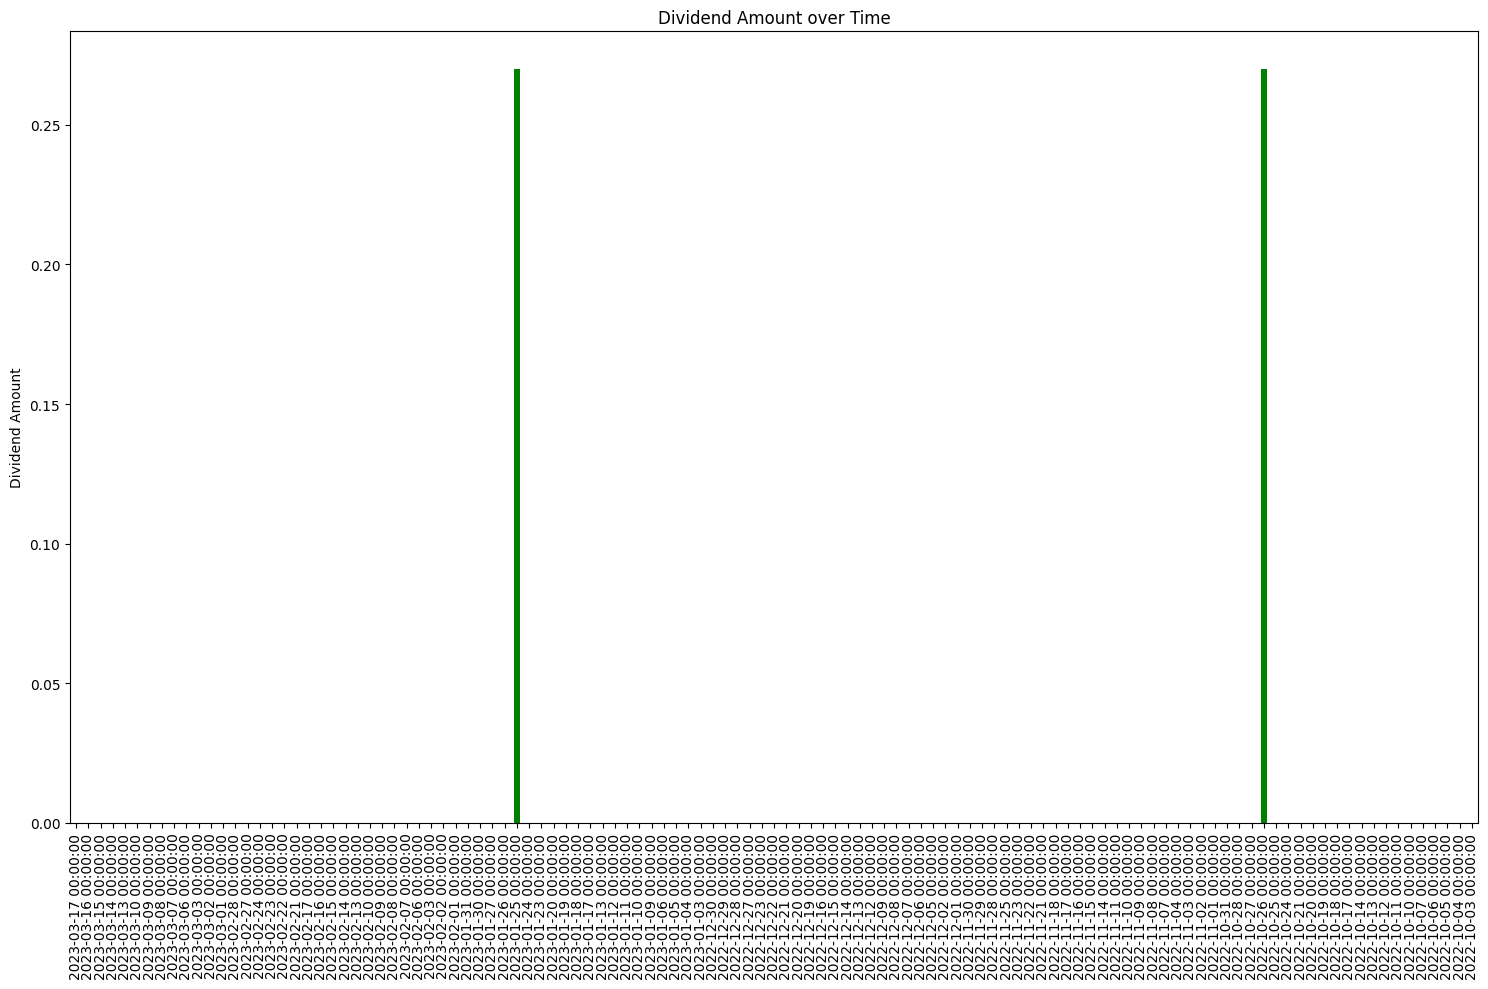

In [280]:
fig, axes = plt.subplots(figsize=(15, 10))

df['7. dividend amount'].plot(kind='bar', ax=axes, color='g')
axes.set_ylabel("Dividend Amount")
axes.set_title("Dividend Amount over Time")
plt.tight_layout()
plt.show()

8. Split Coefficient:
A stock split is a corporate action in which a company increases the number of its outstanding shares by issuing more shares to its current shareholders. 
The split coefficient represents the ratio of new shares to old shares. 
For example, a 2-for-1 split means that a shareholder receives two new shares for each share they previously owned. 
In the case, the split coefficient is 1.0, which indicates that no stock splits have occurred during the displayed time frame. 
A constant split coefficient of 1.0 means that the number of outstanding shares has remained unchanged.

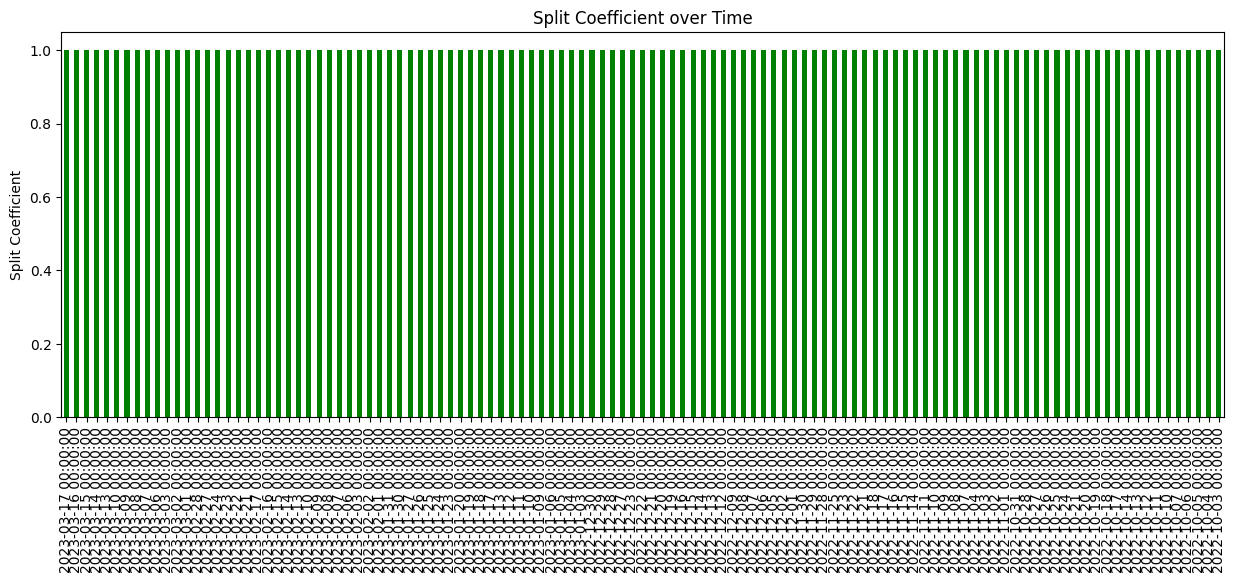

In [281]:
fig, axes = plt.subplots(figsize=(15, 5))

df['8. split coefficient'].plot(kind='bar', ax=axes, color='g')
axes.set_ylabel("Split Coefficient")
axes.set_title("Split Coefficient over Time")
plt.show()

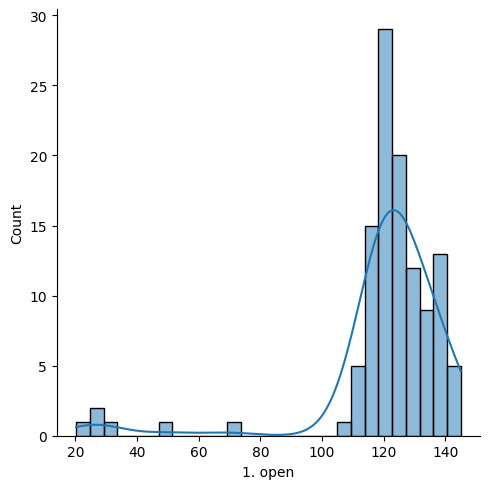

In [282]:
sns.displot(data=df, x="1. open", kde=True)

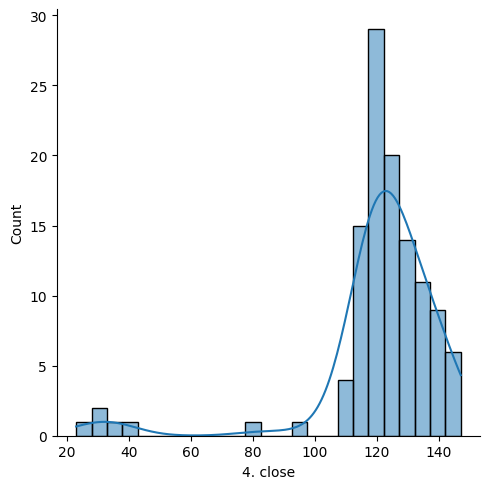

In [283]:
sns.displot(data=df, x="4. close", kde=True)

## Bulding Linear Regression model

In [284]:
X = df.drop('4. close', axis =1)
y = df['4. close']

features_list = X.columns

In [285]:
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state = 10)
lr.fit(X_train,y_train)
predict1 = lr.predict(X_test)


## Result - Accuracy

In [286]:
from sklearn.metrics import mean_squared_error, r2_score 


def calculate_metrics(y_test, y_pred):  
    
    mse = mean_squared_error(y_test, y_pred) 
    rmse = np.sqrt(mse) 
    r2_scors = r2_score(y_test, y_pred) 
    
    print("MSE: ", mse) # 0 means perfect
    print("RMSE: ", rmse) 
    print("R2_score: ", r2_scors) #1 means perfect
    
calculate_metrics(y_test, predict1)


MSE:  0.033151467255594334
RMSE:  0.18207544385664515
R2_score:  0.9999469073213498


In [287]:
from sklearn.linear_model import Lasso

la = Lasso().fit(X_train, y_train )

la_pre = la.predict(X_test) 


In [288]:
print("Lasso Regression model's score: ")
calculate_metrics(y_test, la_pre)

Lasso Regression model's score: 
MSE:  0.0830237120984496
RMSE:  0.28813835582658825
R2_score:  0.9998670360128317


## Predict

In [289]:
day_before = 3
def predict(days, data):
    openn = df.iloc[:3, 0].mean()
    high = df.iloc[:3, 0].mean()
    low = df.iloc[:3, 0].mean()
    adclose = df.iloc[:3, 0].mean()
    volume = df.iloc[:3, 0].mean()
    return pd.DataFrame([[openn, high, low, adclose, volume, 0, 1]], columns = features_list)

predict(day_before, data)
close_price_predict = lr.predict(predict(day_before, data))

# The closing price is 

In [290]:
print(close_price_predict)

[26.54339411]
